In [ ]:
from accelerate import Accelerator
accelerator = Accelerator()
accelerator.prepare(student_model,tearcher_model)

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model_path = "/home/ubuntu/data/exp/proj2410/model/Llama2-7b"
student_model = AutoModelForCausalLM.from_pretrained(model_path)
tearcher_model = AutoModelForCausalLM.from_pretrained(model_path)

Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


In [1]:
from modeling.llama import load_custom_model,restore_to_original_llama


model_path = "/home/ubuntu/data/exp/proj2410/model/Llama2-7b"

model = load_custom_model(model_path)

/home/ubuntu/data/anaconda3/envs/quant/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


In [ ]:
model=restore_to_original_llama(model)
model

In [1]:

from EfficientQAT.quantize.int_linear_real import load_quantized_model
from EfficientQAT.main_block_ap import evaluate
from EfficientQAT.datautils_block import BlockTrainDataset, get_loaders
from EfficientQAT.quantize.crossblockquant import update_dataset
from template.datautils import *

quant_path = "/home/ubuntu/data/exp/proj2410/quant_model/EfficientQAT/w4gs128/Llama2-7b"
quant_model,tokenizer = load_quantized_model(quant_path,4,128)


/home/ubuntu/miniconda3/envs/quant/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading quantized model from /home/ubuntu/data/exp/proj2410/quant_model/EfficientQAT/w4gs128/Llama2-7b


100%|██████████| 32/32 [00:00<00:00, 55.40it/s]


Loading pre-computed quantized weights...
Loading pre-computed quantized weights Successfully


In [25]:
from EfficientQAT.quantize.triton_utils.kernels import *
scale =  quant_model.model.layers[0].self_attn.q_proj.scales
weight = quant_model.model.layers[0].self_attn.q_proj.qweight
zero = quant_model.model.layers[0].self_attn.q_proj.qzeros

maxq = 2**4 -1
weight = dequant_dim0(weight, 4,maxq,4096,4096)
zero = dequant_dim1(zero, 4,maxq,scale.shape[0],scale.shape[1])
weight,weight.shape,zero,zero.shape
weight = ((weight.view(-1, 128, 4096) - zero.view(-1, 1, 4096)) \
           * scale.view(-1, 1, 4096)).reshape(4096, 4096)
weight

tensor([[-0.0066,  0.0129, -0.0190,  ...,  0.0000,  0.0216, -0.0108],
        [-0.0116,  0.0000,  0.0190,  ...,  0.0117,  0.0108, -0.0108],
        [-0.0017,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0010, -0.0071,  0.0000,  ...,  0.0070, -0.0352,  0.0194],
        [ 0.0010, -0.0142,  0.0165,  ..., -0.0281, -0.0176,  0.0155],
        [-0.0005,  0.0071,  0.0000,  ...,  0.0070, -0.0088, -0.0078]],
       device='cuda:0', dtype=torch.float16, grad_fn=<ViewBackward0>)

In [21]:
fp_weight = llm_model.model.layers[0].self_attn.q_proj.weight
int_fp_weight = (fp_weight.view(-1,128,4096)/ scale.view(-1, 1, 4096)).reshape(4096,4096)
int_fp_weight.max()

tensor(7225.3638, device='cuda:0', grad_fn=<MaxBackward1>)

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

from EfficientQAT.quantize.int_linear_fake import UniformAffineQuantizer
import os
os.environ["HF_HOME"] = "/home/ubuntu/data/exp/proj2410/hf_home"
model_path = "/home/ubuntu/data/exp/proj2410/model/Llama2-7b"
llm_model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float32)

/home/ubuntu/miniconda3/envs/quant/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


In [2]:
from easydict import EasyDict
from transformers import AutoTokenizer, AutoModelForCausalLM

from EfficientQAT.main_block_ap import evaluate

tokenizer = AutoTokenizer.from_pretrained(model_path)
args = EasyDict()
args.eval_ppl = True
args.eval_tasks = ""
args.max_memory = "24GB"
args.ppl_seqlen = 2048
args.batch_size = 1
args.calib_dataset = "redpajama"
args.train_size = 1
args.val_size = 1
args.seed = 42
args.training_seqlen = 4096
llm_model = llm_model.to("cuda:0")
evaluate(llm_model,tokenizer,args)

device_map: OrderedDict([('model.embed_tokens', 0), ('model.layers.0', 0), ('model.layers.1', 0), ('model.layers.2', 0), ('model.layers.3', 0), ('model.layers.4', 0), ('model.layers.5', 0), ('model.layers.6', 0), ('model.layers.7', 0), ('model.layers.8', 0), ('model.layers.9', 0), ('model.layers.10', 0), ('model.layers.11', 0), ('model.layers.12', 0), ('model.layers.13', 0), ('model.layers.14', 0), ('model.layers.15', 0), ('model.layers.16', 0), ('model.layers.17', 0), ('model.layers.18', 0), ('model.layers.19', 0), ('model.layers.20', 0), ('model.layers.21', 0), ('model.layers.22', 0), ('model.layers.23', 0), ('model.layers.24', 0), ('model.layers.25', 0), ('model.layers.26', 0), ('model.layers.27', 1), ('model.layers.28', 1), ('model.layers.29', 1), ('model.layers.30', 1), ('model.layers.31', 1), ('model.norm', 1), ('model.rotary_emb', 1), ('lm_head', 1)])
Loading Wikitext-2 dataset...


Using the latest cached version of the dataset since wikitext couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'wikitext-2-raw-v1' at /home/ubuntu/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/0.0.0/b08601e04326c79dfdd32d625aee71d232d685c3 (last modified on Sat Oct 12 23:21:23 2024).
100%|██████████| 166/166 [05:39<00:00,  2.04s/it]


wikitext2: 5.472108840942383
get_c4


Using the latest cached version of the dataset since allenai/c4 couldn't be found on the Hugging Face Hub


ValueError: Couldn't find cache for allenai/c4 for config 'default-c2cff5d7da675c1c'
Available configs in the cache: ['default-b04fc8a0b8562884', 'default-c7bc8b0aefc5e48f']

In [ ]:
import copy
from scipy import stats
for n,m in llm_model.named_modules():
    if "proj" in n:
        raw_weight = m.weight.data.clone()
        avg,std,abs_max,abs_min = raw_weight.mean().item(),raw_weight.std().item(),raw_weight.abs().max().item(),raw_weight.abs().min().item()
        print(n,avg,std,abs_max,abs_min)
        mean,std = torch.mean(raw_weight),torch.std(raw_weight)
        # stat,p = stats.normaltest(((raw_weight-mean)/std).view(-1).cpu().numpy())
        stat,p = stats.kstest(((raw_weight-mean)/std).view(-1).cpu().numpy(),'norm')
        if p > 0.05:
            print("Normal distribution")
        else:
            print(f"Not normal distribution P = : {p}")

In [ ]:
import copy
for n,m in llm_model.named_modules():
    if "proj" in n:
        best_error_cross = torch.inf
        for alpha in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
            raw_weight = copy.deepcopy(m.weight)
            cross_quantizer = CrossQuantizer(n_bits=4,weight=raw_weight,alpha=alpha)
            error_cross = (raw_weight - cross_quantizer.fake_quant(raw_weight)).abs().mean().item()
            if error_cross < best_error_cross:
                best_error_cross = error_cross
                best_alpha = alpha
        raw_weight = copy.deepcopy(m.weight)
        uniform_quantizer = UniformAffineQuantizer(n_bits=4, group_size=128, weight=raw_weight)        
        error_uniform =  raw_weight - uniform_quantizer.fake_quant(raw_weight)
        print(n,error_uniform.abs().mean().item(),best_error_cross,best_alpha)

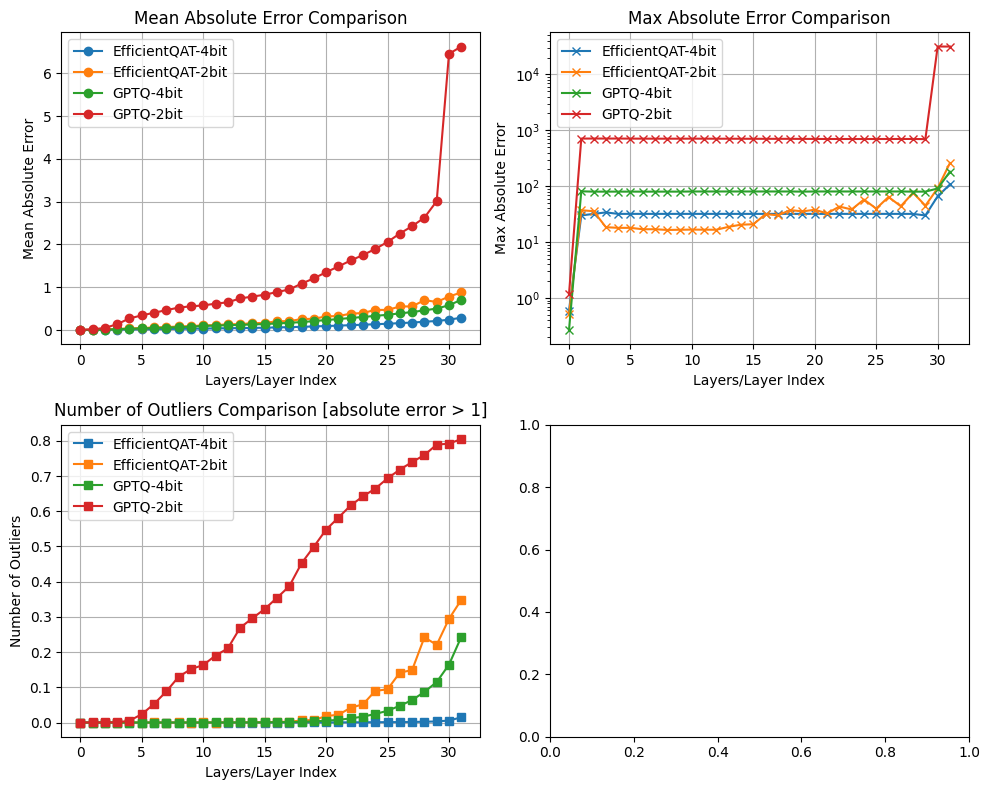

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
out_dir = "/home/ubuntu/data/exp/proj2410/test/"
data_list = json.load(open(os.path.join(out_dir, "abs_test.json"), "r"))

# 初始化图像数据
x_values = np.arange(len(data_list[0]["mean_abs_error"]))  # 假设每个列表长度相同

# 创建三张图
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# 遍历每组数据，绘制每个组合（方法-wbits）的曲线
for data in data_list:
    label = f'{data["method"]}-{data["wbits"]}bit'

    # 画 Mean Absolute Error 的图
    axs[0,0].plot(x_values, data["mean_abs_error"], label=label, marker='o')

    # 画 Max Absolute Error 的图
    axs[0,1].plot(x_values, data["max_abs_error"], label=label, marker='x')

    # 画 Number of Outliers 的图
    axs[1,0].plot(x_values, data["num_outlier"], label=label, marker='s')

# 设置各图的标题、标签和图例
axs[0,0].set_title('Mean Absolute Error Comparison')
axs[0,0].set_xlabel('Layers/Layer Index')
axs[0,0].set_ylabel('Mean Absolute Error')
axs[0,0].legend()
axs[0,0].grid(True)

axs[0,1].set_title('Max Absolute Error Comparison')
axs[0,1].set_xlabel('Layers/Layer Index')
axs[0,1].set_ylabel('Max Absolute Error')
axs[0,1].set_yscale('log')
axs[0,1].legend()
axs[0,1].grid(True)

axs[1,0].set_title('Number of Outliers Comparison [absolute error > 1]')
axs[1,0].set_xlabel('Layers/Layer Index')
axs[1,0].set_ylabel('Number of Outliers')
axs[1,0].legend()
axs[1,0].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "how_quantization_error_in_layer_effect_accuracy.pdf"))


| Model | wikitext2 | c4 |
| --- | --- | --- |
| raw | 5.47 | 6.97 |
| EfficientQAT 4bit | 5.65 | 7.12 |
| EfficientQAT 2bit | 10.36 | 11.82 |
| GPTQ 4bit | 6.32 | 7.77 |
| GPTQ 2bit | nan | nan |   

In [1]:
import os

import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer

from template.datautils import *

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

model_path = "/home/ubuntu/data/exp/proj2410/model/Llama2-7b"

llm_model= AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_path,use_fast=True)

trainenc, valenc = get_loaders("redpajama",tokenizer,128)

/home/ubuntu/miniconda3/envs/quant/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:09<00:00,  3.08s/it]


get_redpajama


In [ ]:
from torch.optim import SGD


def get_llm_module(model: nn.Module,name: str):
    for module in model.named_modules():
        if module[0] == name:
            return module[1]
        return None
def fake_quantize_tensor(tensor: torch.tensor, bits: int):
    rel_max = tensor.max()-tensor.min()
    scale = (2 ** bits - 1 ) / rel_max
    zero_point = tensor.min()
    return torch.round((tensor - zero_point)/scale)*scale + zero_point

def fake_quantize(model: nn.Module, name: str, bits: int):
    module = get_llm_module(model, name)
    if module is None:
        return
    module.weight = nn.Parameter(fake_quantize_tensor(module.weight, bits))
    module.bias = nn.Parameter(fake_quantize_tensor(module.bias, bits))

def grad_exp(model: AutoModelForCausalLM, train_data:list ):
    # essamble list to tensor 
    optimizer = SGD(model.parameters(), lr=5e-5)
    optimizer.zero_grad()
    loss_func = nn.CrossEntropyLoss()
    train_data= [i[0] for i in train_data]
    input_ids = torch.stack(train_data)
    input_ids = input_ids.squeeze(1)
    reistred_outputs = model(input_ids=input_ids)
    for module_name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            fake_quantize(model, module_name, 4)
    outputs = model(input_ids=input_ids)
    loss = loss_func(outputs.logits, reistred_outputs.logits)
    loss.backward()
grad_exp(llm_model, trainenc)

In [3]:
import torch
import torch.nn as nn
import gc

# Define a function to check if tensors are still alive in GPU memory and print memory usage
def check_memory_and_device(layers, message):
    print(f"\n{message}")
    for i, layer in enumerate(layers):
        try:
            print(f"Layer {i} on {next(layer.parameters()).device}")
        except StopIteration:
            print(f"Layer {i} has no parameters.")
    print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
    print(f"Memory Reserved: {torch.cuda.memory_reserved()} bytes")

# Define original layers (ModuleList)
layers = nn.ModuleList([nn.Linear(10, 10).to('cuda') for _ in range(5)])
check_memory_and_device(layers, "Original layers on GPU:")

# Perform slicing operation
start_idx = 1
end_idx = 3
ori_layers = layers[start_idx:end_idx]

# Move the corresponding qlayers to CPU and replace
qlayers = nn.ModuleList([nn.Linear(10, 10) for _ in range(5)])

# Manual replacement using a loop
for i in range(start_idx, end_idx):
    layers[i] = qlayers[i].to('cpu')

check_memory_and_device(layers, "Layers after replacement:")

# Delete original layers
del ori_layers
gc.collect()  # Force garbage collection
torch.cuda.empty_cache()  # Clear GPU cache manually

check_memory_and_device(layers, "After deletion and GC:")



Original layers on GPU:
Layer 0 on cuda:0
Layer 1 on cuda:0
Layer 2 on cuda:0
Layer 3 on cuda:0
Layer 4 on cuda:0
Memory Allocated: 10240 bytes
Memory Reserved: 2097152 bytes

Layers after replacement:
Layer 0 on cuda:0
Layer 1 on cpu
Layer 2 on cpu
Layer 3 on cuda:0
Layer 4 on cuda:0
Memory Allocated: 10240 bytes
Memory Reserved: 2097152 bytes

After deletion and GC:
Layer 0 on cuda:0
Layer 1 on cpu
Layer 2 on cpu
Layer 3 on cuda:0
Layer 4 on cuda:0
Memory Allocated: 8192 bytes
Memory Reserved: 2097152 bytes


In [1]:
import csv
import os

class BlockLossRecorder:
    def __init__(self, file_path:str):
        """
        初始化 BlockLossRecorder
        :param file_path: 用于存储loss记录的文件路径
        """
        self.file_path = file_path
        self.loss_data = {}

        # 如果文件存在，则从文件中加载已有的数据
        if os.path.exists(self.file_path):
            self._load_from_file()

    def record(self, blk_id:str, step:int, loss:float):
        """
        记录指定 block 和 step 的 loss 值
        :param blk_id: block 的 ID
        :param step: 当前 step
        :param loss: 当前 step 对应的 loss
        """
        if blk_id not in self.loss_data:
            self.loss_data[blk_id] = []
        self.loss_data[blk_id].append((step, loss))

    def save_to_file(self):
        """
        将记录的 loss 数据保存到文件
        """
        with open(self.file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["blk_id", "step", "loss"])
            for blk_id, records in self.loss_data.items():
                for step, loss in records:
                    writer.writerow([blk_id, step, loss])

    def _load_from_file(self):
        """
        从文件中加载 loss 数据
        """
        with open(self.file_path, mode='r') as file:
            reader = csv.reader(file)
            next(reader)  # 跳过表头
            for row in reader:
                blk_id, step, loss = row[0], int(row[1]), float(row[2])
                if blk_id not in self.loss_data:
                    self.loss_data[blk_id] = []
                self.loss_data[blk_id].append((step, loss))

    def get_loss_data(self, blk_id):
        """
        获取指定 block ID 对应的 loss 数据
        :param blk_id: block 的 ID
        :return: 对应的 step 和 loss 列表
        """
        return self.loss_data.get(blk_id, [])

import matplotlib.pyplot as plt
import numpy as np
def plot_loss(block_loss_data, blk_id, downsample_step=25, smoothing_window=25):
    """
    使用matplotlib绘制指定block的loss曲线，支持下采样和移动平均
    :param block_loss_data: 某个block的step和loss数据
    :param blk_id: 要绘制的block ID
    :param downsample_step: 下采样步长（每n个step显示一个点）
    :param smoothing_window: 移动平均的窗口大小
    """
    if not block_loss_data:
        print(f"没有找到 block {blk_id} 的 loss 数据")
        return

    steps, losses = zip(*block_loss_data)  # 解压出 step 和 loss

    # 进行下采样
    steps = steps[::downsample_step]
    losses = losses[::downsample_step]

    # 计算移动平均
    smooth_losses = np.convolve(losses, np.ones(smoothing_window)/smoothing_window, mode='valid')

    # 调整steps以匹配平滑后的loss长度
    smooth_steps = steps[:len(smooth_losses)]

    plt.figure(figsize=(10, 6))
    plt.plot(smooth_steps, smooth_losses, label=f'Block {blk_id} (Smoothed)', marker='o')
    # 使用散点图代替折线图
    # plt.scatter(smooth_steps, smooth_losses, label=f'Block {blk_id} (Smoothed)', marker='o')

    # 设置标题和标签
    plt.title(f'Loss Curve for Block {blk_id} (Smoothed)')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


# # 示例用法
# if __name__ == "__main__":
loss_dir="/home/ubuntu/data/exp/proj2410/logs"
file = os.path.join(loss_dir,"Llama2-7b-efficientqat-w4gs128.csv")
# file = os.path.join(loss_dir,"Llama2-7b-efficientqat-w4gs128-mad.csv")
recorder = BlockLossRecorder(file)

# 读取数据用于画图
# loss_data = recorder.get_loss_data("28")
# print("block1的loss数据:", loss_data)


# plot_loss(loss_data, "28")

In [2]:
data=[]
for i in range(32):
    loss_data =recorder.get_loss_data(f"blk{i}-{i+1}")
    _,loss_data = zip(*loss_data)
    data.append(loss_data)
len(data),len(data[0])
min(data[0][:512]),min(data[0][512:1024]),min(data[0][1024:1536]),min(data[0][1536:2048]),min(data[0][2048:2560])


# data =recorder.get_loss_data("crossblock_loss")
# _,data = zip(*data)
# data = np.array(data)
# print(data.shape)

(6.505366059172957e-07,
 5.78379570015386e-07,
 5.699643566003942e-07,
 5.527489292944665e-07,
 5.521980028788676e-07)

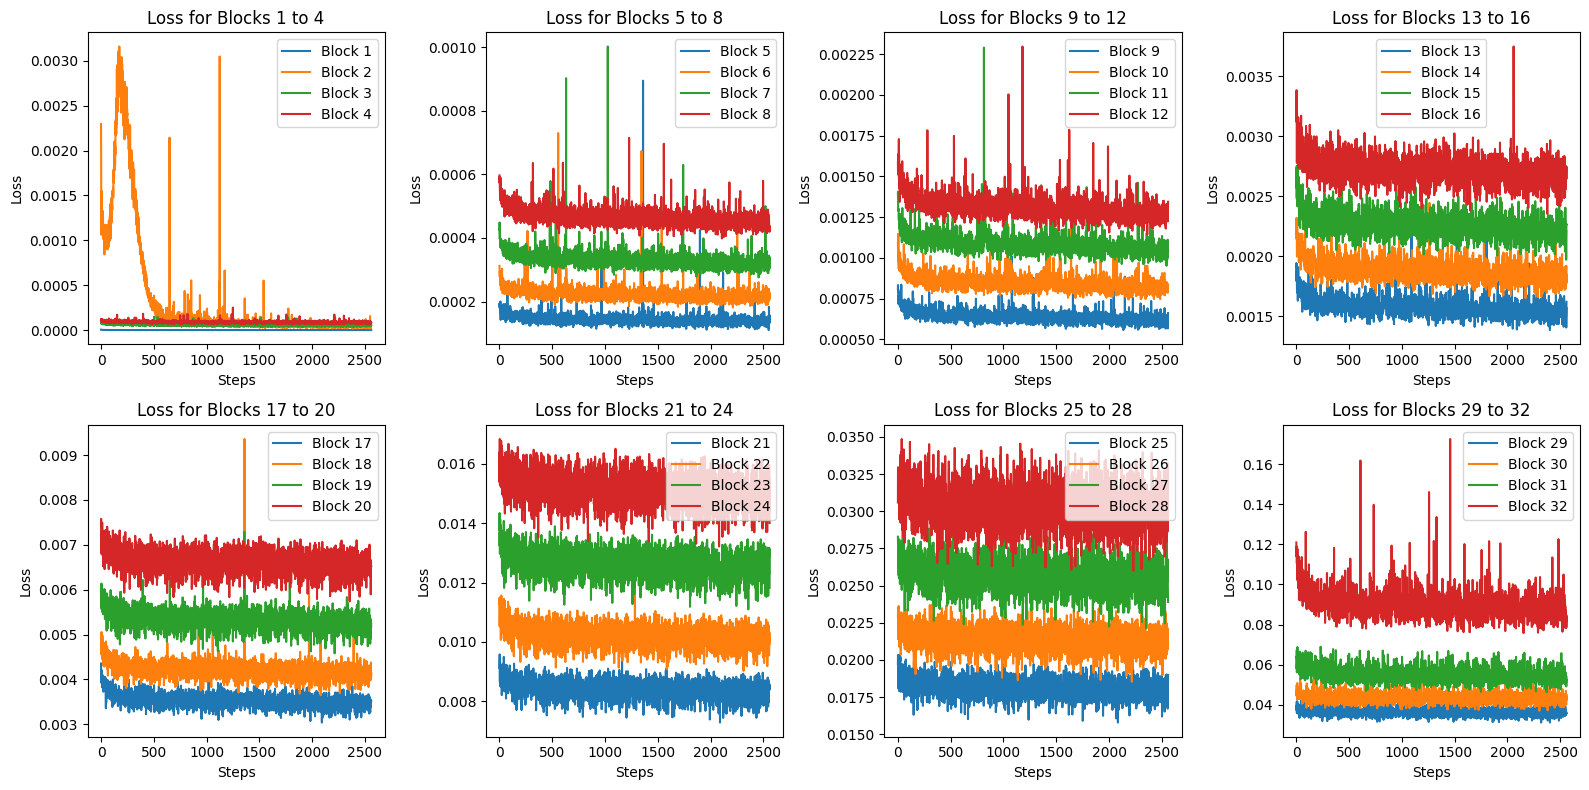

In [3]:

import matplotlib.pyplot as plt
import numpy as np
out_dir = "/home/ubuntu/data/exp/proj2410/test/"
loss = np.array(data)
# Number of blocks to group in each plot
blocks_per_plot = 4
total_blocks = loss.shape[0]
steps = loss.shape[1]

# Plot the loss for each block group in 8 plots
fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 4 rows, 2 columns of subplots

for i in range(8):
    ax = axs[i // 4, i % 4]
    for blk in range(i * blocks_per_plot, (i + 1) * blocks_per_plot):
        ax.plot(range(steps), loss[blk], label=f'Block {blk+1}')
    ax.set_title(f'Loss for Blocks {i*blocks_per_plot + 1} to {(i+1)*blocks_per_plot}')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
# plt.savefig(os.path.join(out_dir, 'different_block_loss_spike.pdf'))
plt.savefig(os.path.join(out_dir, 'different_block_loss_spike-mad.pdf'))


In [1]:
import torch
import gc

def get_tensor_size(tensor):
    """获取张量的内存大小，单位是字节"""
    return tensor.numel() * tensor.element_size()

def profile_memory(obj):
    """统计给定对象的内存占用，包括 nn.Module 和包含 Tensor 的其他对象"""
    total_size = 0
    device_memory = {}
    
    def process_tensor(tensor):
        """处理一个张量并更新总内存统计"""
        nonlocal total_size
        size = get_tensor_size(tensor)
        total_size += size
        device = tensor.device.type
        if device not in device_memory:
            device_memory[device] = 0
        device_memory[device] += size

    def process_object(obj):
        """递归处理对象及其属性"""
        if isinstance(obj, torch.nn.Module):
            # 处理 nn.Module 的参数和缓冲区
            for param in obj.parameters():
                process_tensor(param)
            for buffer in obj.buffers():
                process_tensor(buffer)
        elif isinstance(obj, torch.Tensor):
            # 如果对象本身就是张量
            process_tensor(obj)
        elif hasattr(obj, '__dict__'):
            # 处理其他对象，递归检查其属性
            for attr_name, attr_value in vars(obj).items():
                process_object(attr_value)
        elif isinstance(obj, list) or isinstance(obj, tuple) or isinstance(obj, set):
            # 处理容器类型
            for item in obj:
                process_object(item)
        elif isinstance(obj, dict):
            # 处理字典
            for key, value in obj.items():
                process_object(value)

    # 开始递归处理对象
    process_object(obj)

    # 计算结果
    total_mb = total_size / (1024 ** 2)
    device_memory_mb = {k: v / (1024 ** 2) for k, v in device_memory.items()}

    return {
        "total_memory_bytes": total_size,
        "total_memory_MB": total_mb,
        "device_memory_MB": device_memory_mb
    }

# Example usage:
# For nn.Module
# model = torch.nn.Linear(100, 200)
# memory_profile = profile_memory(model)
# print(memory_profile)

# # For a dataset containing Tensors
# class CustomDataset:
#     def __init__(self):
#         self.data = torch.randn(1000, 1000)
#         self.labels = torch.randint(0, 10, (1000,))

# dataset = CustomDataset()
# memory_profile = profile_memory(dataset)
# print(memory_profile)

# # 清除 PyTorch 缓存并手动运行垃圾回收器（有助于更准确的内存统计）
# torch.cuda.empty_cache()
# gc.collect()

import os

import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer

from template.datautils import *

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

model_path = "/home/ubuntu/data/exp/proj2410/model/Llama2-7b"

llm_model= AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
memory_profile = profile_memory(llm_model)
print(memory_profile)

/home/ubuntu/data/anaconda3/envs/quant/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:08<00:00,  2.95s/it]

{'total_memory_bytes': 27020779520, 'total_memory_MB': 25769.0234375, 'device_memory_MB': {'cuda': 25769.0234375}}


考虑低频成分信息的量化方案

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import GPT2Model, GPT2Config
import torch.nn.functional as F

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义GPT-2风格的模型
class SimpleGPT2(nn.Module):
    def __init__(self):
        super(SimpleGPT2, self).__init__()
        config = GPT2Config(n_layer=4, n_head=4, n_embd=256)
        self.gpt2 = GPT2Model(config)
        self.linear = nn.Linear(256, 1)  # 假设是一个回归任务

    def forward(self, x, attention_mask=None):
        outputs = self.gpt2(inputs_embeds=x, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        output = self.linear(hidden_states[:, -1, :])  # 取最后一个token的输出
        return output

# 定义低频傅里叶损失函数
def low_freq_fourier_loss(WX, QX, freq_ratio=0.1, loss_type='mse'):
    # 对时间序列的最后一维进行傅里叶变换
    WX_fft = torch.fft.fft(WX, dim=-1)
    QX_fft = torch.fft.fft(QX, dim=-1)

    # 只保留低频成分，设置高频部分为 0
    low_freq_limit = int(WX_fft.size(-1) * freq_ratio)
    WX_fft[..., low_freq_limit:] = 0
    QX_fft[..., low_freq_limit:] = 0

    # 进行逆傅里叶变换回到时域
    WX_low_freq = torch.fft.ifft(WX_fft, dim=-1).real
    QX_low_freq = torch.fft.ifft(QX_fft, dim=-1).real

    # 计算低频部分的损失
    if loss_type == 'kl':
        WX_log_prob = F.log_softmax(WX_low_freq, dim=-1)
        QX_prob = F.softmax(QX_low_freq, dim=-1)
        loss = F.kl_div(WX_log_prob, QX_prob, reduction='batchmean')
    elif loss_type == 'mse':
        loss = F.mse_loss(WX_low_freq, QX_low_freq)
    else:
        raise ValueError(f"Unsupported loss type: {loss_type}")

    return loss

# 定义量化器
class UniformAffineQuantizer(nn.Module):
    def __init__(self, n_bits: int = 8, group_size=None, weight=None):
        super().__init__()
        assert 2 <= n_bits <= 16, "bitwidth not supported"
        self.n_bits = n_bits
        self.qmin = 0
        self.qmax = 2 ** n_bits - 1
        self.group_size = group_size if group_size != -1 else weight.shape[-1]
        assert weight.shape[-1] % group_size == 0
        self.enable = True
        
        # init scale and zero point through Max-Min quantization
        with torch.no_grad():
            if weight is not None:
                x = weight.reshape(-1, self.group_size)
                xmin = x.amin([-1], keepdim=True)
                xmax = x.amax([-1], keepdim=True)
                range = xmax - xmin
                scale = range / (2**self.n_bits - 1)
                scale = scale.clamp(min=1e-4, max=1e4)
                zero_point = -(xmin / scale).clamp(min=-1e4, max=1e4)
                self.scale = nn.Parameter(scale)
                self.zero_point = nn.Parameter(zero_point.round())

    def change_n_bits(self, n_bits):
        self.n_bits = n_bits
        self.qmin = 0
        self.qmax = int(2 ** n_bits - 1)
        
    def fake_quant(self, x):
        scale = clamp_ste(self.scale, 1e-4, 1e4)
        round_zero_point = clamp_ste(round_ste(self.zero_point), self.qmin, self.qmax)
        
        dim1, dim2 = x.shape
        x = x.reshape(-1, self.group_size)
        x_int = round_ste(x / scale)
        if round_zero_point is not None:
            x_int = x_int.add(round_zero_point)
        x_int = x_int.clamp(self.qmin, self.qmax)
        x_dequant = x_int
        if round_zero_point is not None:
            x_dequant = x_dequant.sub(round_zero_point)
        x_dequant = x_dequant.mul(scale)
        if self.group_size:
            x_dequant = x_dequant.reshape(dim1, dim2)
        return x_dequant
    
    def forward(self, x: torch.Tensor):
        if self.n_bits >= 16 or not self.enable:
            return x

        x_dequant = self.fake_quant(x)
        return x_dequant

# 定义 STE 函数
def round_ste(x: torch.Tensor):
    """
    Implement Straight-Through Estimator for rounding operation.
    """
    return (x.round() - x).detach() + x

def clamp_ste(x: torch.Tensor, min, max):
    return (x.clamp(min, max) - x).detach() + x

# 加载数据集（以简单的时序数据为例）
def generate_synthetic_data(num_samples=1000, seq_length=50, feature_size=256):
    X = torch.randn((num_samples, seq_length, feature_size))
    y = torch.randn((num_samples, 1))
    return X, y

train_X, train_y = generate_synthetic_data()
test_X, test_y = generate_synthetic_data(num_samples=200)
train_loader = torch.utils.data.DataLoader(list(zip(train_X, train_y)), batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(test_X, test_y)), batch_size=16, shuffle=False)

# 初始化模型和优化器
model = SimpleGPT2().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练函数
def train(model, loss_fn, optimizer, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

# 验证函数
def validate(model, test_loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.mse_loss(output, target)
            total_loss += loss.item()
    average_loss = total_loss / len(test_loader)
    print(f"Validation Loss: {average_loss:.4f}")
    return average_loss

# 定义标准的 MSE 损失函数
mse_loss = nn.MSELoss()

# 训练模型并验证
print("Training with MSE Loss")
train(model, mse_loss, optimizer, train_loader)
validate(model, test_loader)

# 使用量化器对模型进行量化蒸馏并验证
def layerwise_quant_distillation(model, quantizer, train_loader, optimizer, loss_fn, epochs=1):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()

            # 对除 Embedding 之外的所有线性层进行量化对齐
            for name, module in model.named_modules():
                if isinstance(module, nn.Linear) and 'embed' not in name.lower():
                    with torch.no_grad():
                        original_output = module(data)
                    quantized_weight = quantizer(module.weight)
                    module.weight.data = quantized_weight
                    quantized_output = module(data)
                    loss = loss_fn(quantized_output, original_output)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()

                    # 使用低频傅里叶损失进行额外的对齐
                    with torch.no_grad():
                        original_output = module(data)
                    quantized_output = module(data)
                    loss = low_freq_fourier_loss(original_output, quantized_output, freq_ratio=0.1, loss_type='mse')
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()

        print(f"Epoch {epoch + 1}, Layerwise Quant Distillation Loss: {running_loss / len(train_loader)}")

# 对模型进行量化蒸馏并验证
quantizer = UniformAffineQuantizer(n_bits=4, weight=model.linear.weight)
print("Performing layerwise quantization distillation")
layerwise_quant_distillation(model, quantizer, train_loader, optimizer, nn.MSELoss(), epochs=1)
print("Validating quantized model")
validate(model, test_loader)

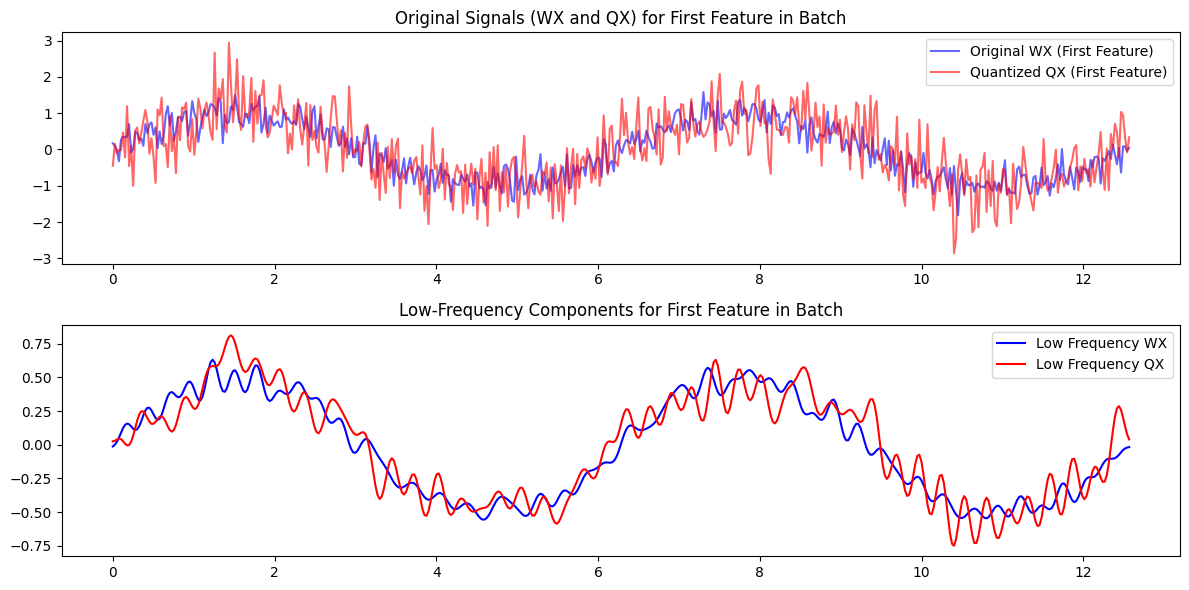

Loss value: 0.02305016480386257
MSE of WX and QX: 0.4518953263759613


In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 定义低频傅里叶损失函数，适应 (batch, lens, dim) 形状
def low_freq_fourier_loss(WX, QX, freq_ratio=0.1, loss_type='mse'):
    # 对时间序列的最后一维（lens）进行傅里叶变换
    WX_fft = torch.fft.fft(WX, dim=1)
    QX_fft = torch.fft.fft(QX, dim=1)

    # 只保留低频成分，设置高频部分为 0
    low_freq_limit = int(WX_fft.size(1) * freq_ratio)  # 基于序列长度截断频率
    WX_fft[:, low_freq_limit:, :] = 0  # 截断高频部分
    QX_fft[:, low_freq_limit:, :] = 0

    # 进行逆傅里叶变换回到时域
    WX_low_freq = torch.fft.ifft(WX_fft, dim=1).real
    QX_low_freq = torch.fft.ifft(QX_fft, dim=1).real

    # 计算低频部分的损失
    if loss_type == 'mse':
        loss = F.mse_loss(WX_low_freq, QX_low_freq)
    else:
        raise ValueError(f"Unsupported loss type: {loss_type}")

    return loss, WX_low_freq, QX_low_freq

# 生成示例数据
batch_size = 2
lens = 500
dim = 64
x = np.linspace(0, 4 * np.pi, lens)
# 扩展正弦信号到 (batch_size, lens, dim) 的形状
WX = np.sin(x)[np.newaxis, :, np.newaxis] + 0.3 * np.random.normal(size=(batch_size, lens, dim))  # 原始信号带噪声
QX = np.sin(x)[np.newaxis, :, np.newaxis] + 0.6 * np.random.normal(size=(batch_size, lens, dim))  # 量化后的信号带更多噪声

# 转换为 PyTorch tensor
WX_tensor = torch.tensor(WX, dtype=torch.float32)
QX_tensor = torch.tensor(QX, dtype=torch.float32)

# 计算低频傅里叶损失并提取低频分量
loss, WX_low_freq, QX_low_freq = low_freq_fourier_loss(WX_tensor, QX_tensor)

# 对第一个batch样本进行绘图，展示低频分量
WX_low_freq_np = WX_low_freq[0, :, 0].numpy()  # 取第一个样本第一个特征维度
QX_low_freq_np = QX_low_freq[0, :, 0].numpy()

# 绘制原始信号和低频分量
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(x, WX[0, :, 0], label='Original WX (First Feature)', color='blue', alpha=0.6)
plt.plot(x, QX[0, :, 0], label='Quantized QX (First Feature)', color='red', alpha=0.6)
plt.title('Original Signals (WX and QX) for First Feature in Batch')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x, WX_low_freq_np, label='Low Frequency WX', color='blue')
plt.plot(x, QX_low_freq_np, label='Low Frequency QX', color='red')
plt.title('Low-Frequency Components for First Feature in Batch')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Loss value: {loss.item()}")
print(f"MSE of WX and QX: {F.mse_loss(WX_tensor, QX_tensor).item()}")
